In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import warnings
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from yellowbrick.model_selection import ValidationCurve #pip install yellowbrick before running this command
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
import itertools
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from fancyimpute import IterativeImputer #pip install fancyimpute before running this command
from yellowbrick.features.importances import FeatureImportances
warnings.filterwarnings('ignore')
%matplotlib inline

In [314]:
filepath = "D:\\adity\\Downloads\\Enova\\"
data = pd.read_csv(filepath + "training_data.csv", na_values = ['?'])
data.head()

,id,diagnosis_date,gleason_score,t_score,n_score,m_score,stage,age,race,height,...,symptoms,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,survival_7_years
0,1,Jun-05,4.0,T1c,N0,M0,I,86.0,4.0,66.0,...,U03,0,0,1,1,0,1,1,1,0
1,2,Feb-06,8.0,T3a,N1,M0,IV,66.0,2.0,70.0,...,"U06,S07",1,1,1,0,0,0,1,1,0
2,3,Mar-06,9.0,T1a,N0,M0,IIB,84.0,4.0,69.0,...,"U01,U02,U03,S10",1,1,0,0,1,1,1,1,1
3,4,Feb-05,8.0,T2b,N0,M0,IIB,86.0,3.0,69.0,...,"U01,U02,S10,O11",0,0,0,1,0,1,1,0,0
4,5,Dec-01,8.0,T4,N0,M0,IV,78.0,4.0,70.0,...,"U01,U03,U05,S07",1,1,1,0,0,0,1,1,0


### Exploring the data

In [315]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15385 entries, 0 to 15384
Data columns (total 33 columns):
id                      15385 non-null int64
diagnosis_date          15385 non-null object
gleason_score           15065 non-null float64
t_score                 15385 non-null object
n_score                 15385 non-null object
m_score                 15385 non-null object
stage                   15385 non-null object
age                     14637 non-null float64
race                    15220 non-null float64
height                  14021 non-null float64
weight                  14068 non-null float64
family_history          13799 non-null float64
first_degree_history    13799 non-null float64
previous_cancer         13799 non-null float64
smoker                  13799 non-null float64
side                    15385 non-null object
tumor_diagnosis         15082 non-null float64
tumor_6_months          5322 non-null float64
tumor_1_year            13262 non-null float64
psa_dia

In [316]:
percentage_missing = (data.isnull().sum()*100)/(len(data))
print(percentage_missing)

id                       0.000000
diagnosis_date           0.000000
gleason_score            2.079948
t_score                  0.000000
n_score                  0.000000
m_score                  0.000000
stage                    0.000000
age                      4.861878
race                     1.072473
height                   8.865778
weight                   8.560286
family_history          10.308742
first_degree_history    10.308742
previous_cancer         10.308742
smoker                  10.308742
side                     0.000000
tumor_diagnosis          1.969451
tumor_6_months          65.407865
tumor_1_year            13.799155
psa_diagnosis            9.086773
psa_6_months            61.767956
psa_1_year              16.360091
tea                     10.308742
symptoms                 2.664933
rd_thrpy                 0.000000
h_thrpy                  0.000000
chm_thrpy                0.000000
cry_thrpy                0.000000
brch_thrpy               0.000000
rad_rem       

### Because of high percentage of missing values, columns psa_6_months and tumor_6_months are removed. The reason I do not want to impute these columns is that the missing values is so high that imputing values in synonymous to introducing synthetic data. Also the columns id, diagnosis_date can be removed as they do not play any role in our prediction.

In [317]:
data.drop(['id','diagnosis_date','psa_6_months','tumor_6_months'], axis=1, inplace=True)

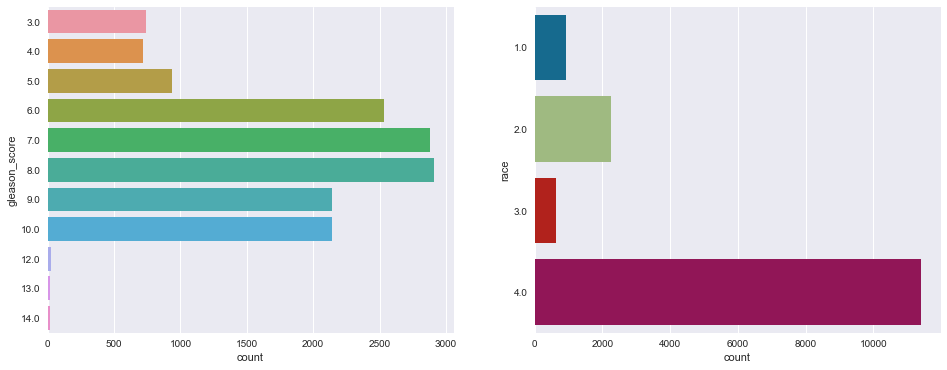

In [173]:
sn.set_style('darkgrid')
fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y="gleason_score",data=data, ax=ax[0])
sn.countplot(y="race",data=data, ax=ax[1])

plt.show()

### Cases with a gleason score of above 10 are almost negligible. Most of the cases belong to race 4 and hence we expect race to not play a major role in prediction as it offers very low variation

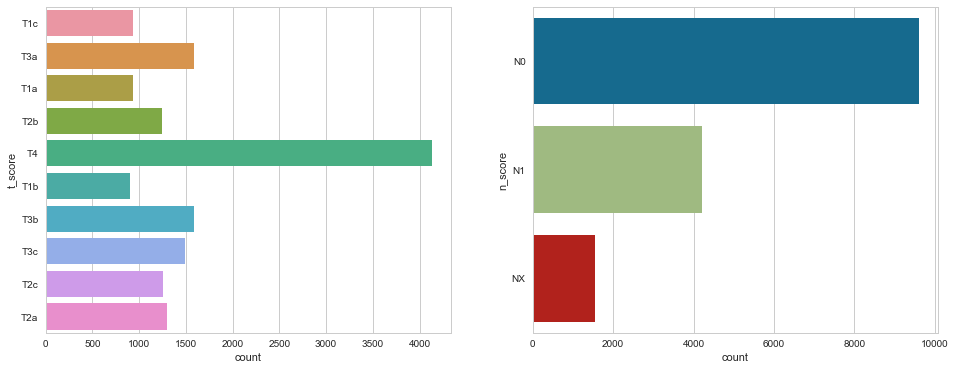

In [129]:
sn.set_style('whitegrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "t_score", data = data, ax = ax[0])
sn.countplot(y = "n_score", data = data, ax = ax[1])
plt.show()

### More than 50% of the cases have n_score as N0 and hence this variable may not have an impact on prediction

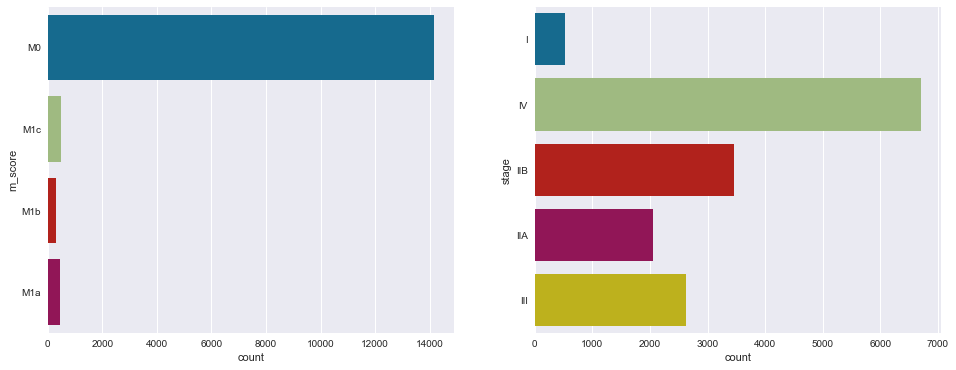

In [130]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "m_score", data = data, ax = ax[0])
sn.countplot(y = "stage", data = data, ax = ax[1])
plt.show()

### m_score will not have an impact on prediction whereas stage might offer some valuable information

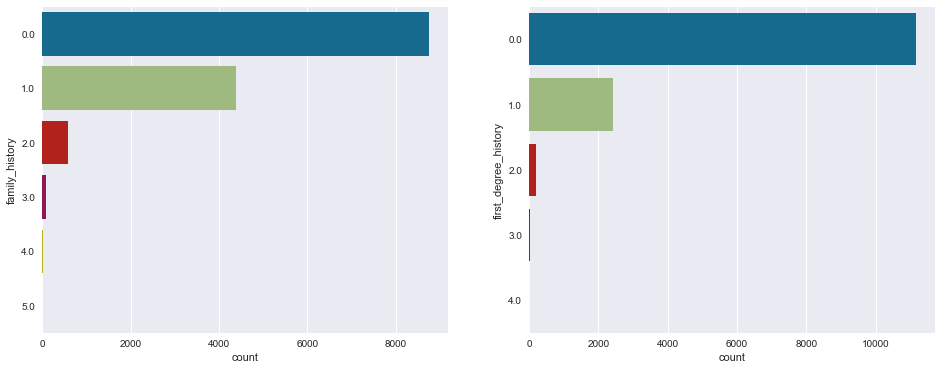

In [131]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "family_history", data = data, ax = ax[0])
sn.countplot(y = "first_degree_history", data = data, ax = ax[1])
plt.show()

### More than 90% of the cases in both variables fall under 2 specific categories and hence these 2 variables might not divulge much information.

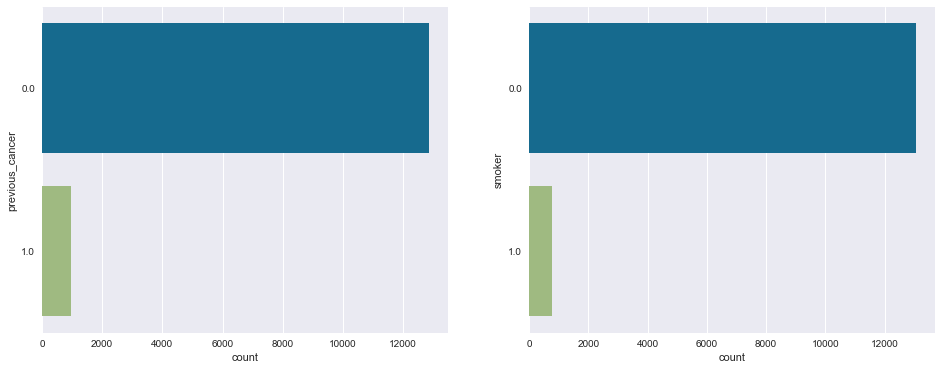

In [132]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "previous_cancer", data = data, ax = ax[0])
sn.countplot(y = "smoker", data = data, ax = ax[1])
plt.show()

### More than 90% of the cases in both variables fall under a specific category and hence these 2 variables might not divulge much information.

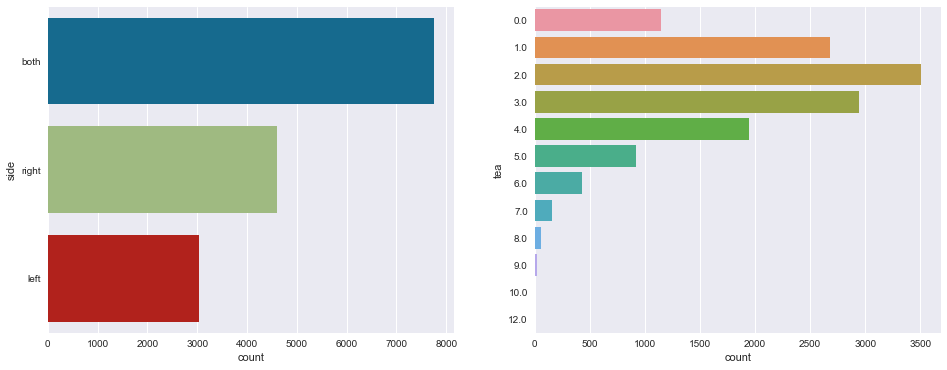

In [133]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "side", data = data, ax = ax[0])
sn.countplot(y = "tea", data = data, ax = ax[1])
plt.show()

### There is significant variation in the 2 variables and it is worth introspecting them

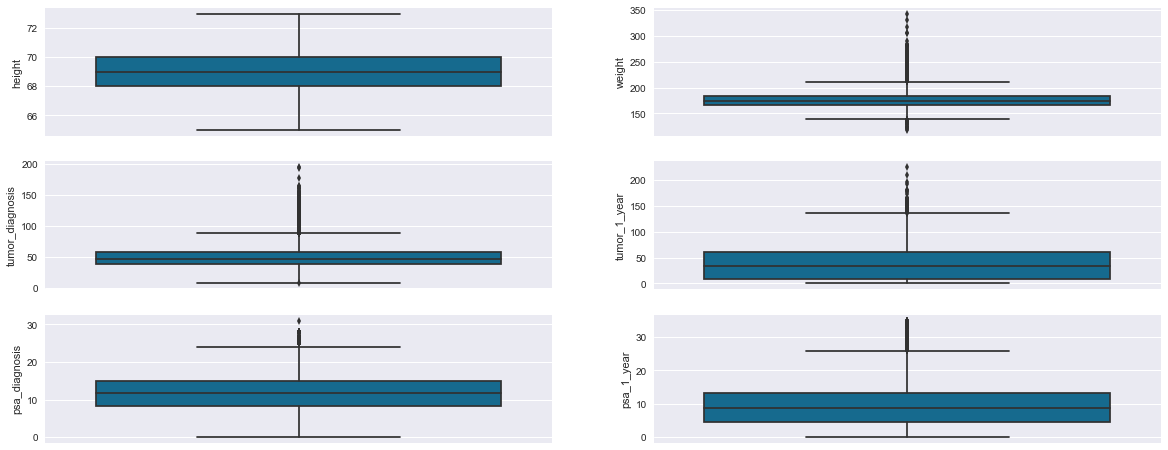

In [134]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(3,2,figsize=(20,8))
sn.boxplot(y = "height", data = data, ax = ax[0,0], orient = 'v')
sn.boxplot(y = "weight", data = data, ax = ax[0,1], orient = 'v')
sn.boxplot(y = "tumor_diagnosis", data = data, ax = ax[1,0], orient = 'v')
sn.boxplot(y = "tumor_1_year", data = data, ax = ax[1,1], orient = 'v')
sn.boxplot(y = "psa_diagnosis", data = data, ax = ax[2,0], orient = 'v')
sn.boxplot(y = "psa_1_year", data = data, ax = ax[2,1], orient = 'v')
plt.show()

### Variables height, weight and psa_diagnosis and tumor_diagnosis are more or less normally distributed with a few outliers. Tumor_1_year and psa_1_year and left skewed and need transformations. 

### Checking for correlation between variables in the dataset

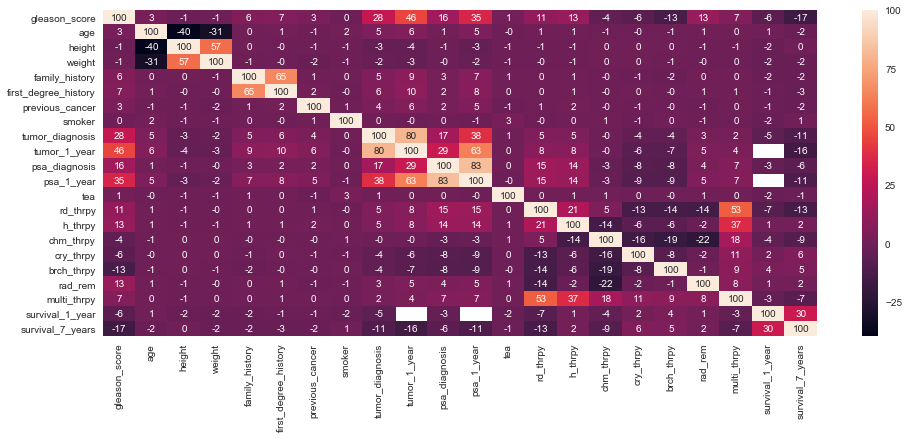

In [136]:
num_columns1 = data.drop(['race','side'], axis = 1)
correlations1 = num_columns1.corr(method='spearman')
sn.set_style('white')
plt.figure(figsize=(16,6))

# Plot heatmap of annotated correlations
sn.heatmap(correlations1*100, annot=True, fmt='.0f' )

### Variables (first_degree_history,family_history), (tumor_1_year,tumor_diagnosis), (psa_1_year,tumor_1_year) and (psa_1_year,psa_dignosis) are highly correlated with each other and it would be prudent if we use some of these variables in our analysis instead of considering every single variable.

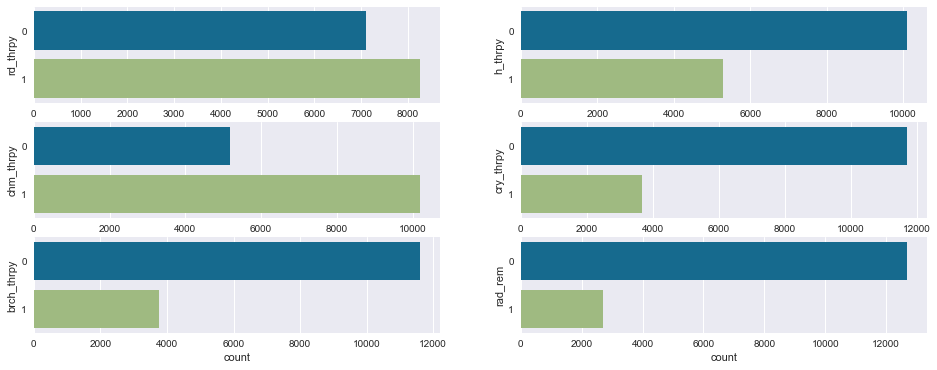

In [137]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(3,2,figsize=(16,6))
sn.countplot(y = "rd_thrpy", data = data, ax = ax[0,0])
sn.countplot(y = "h_thrpy", data = data, ax = ax[0,1])
sn.countplot(y = "chm_thrpy", data = data, ax = ax[1,0])
sn.countplot(y = "cry_thrpy", data = data, ax = ax[1,1])
sn.countplot(y = "brch_thrpy", data = data, ax = ax[2,0])
sn.countplot(y = "rad_rem", data = data, ax = ax[2,1])
plt.show()

### Variables rad_rem, cry_thrpy and brch_thrpy has very little positive instances compared to negative instances and hence may be not useful for our predictions

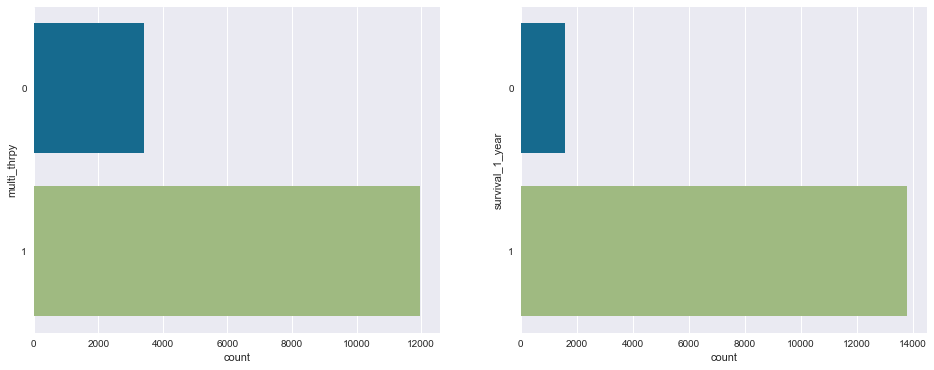

In [138]:
sn.set_style('darkgrid')

fig,ax = plt.subplots(1,2,figsize=(16,6))
sn.countplot(y = "multi_thrpy", data = data, ax = ax[0])
sn.countplot(y = "survival_1_year", data = data, ax = ax[1])

### Multi_thrpy has a lot of positive instances but significantly less number of negative instances. This dataset also comprises of a high number of 1-year survival instances which may not turn out to be significant

### Handling of symptoms column

In [318]:
symptom = data['symptoms'].astype(str)
symp = []
for line in symptom:
    symp.append((line.strip()).split(','))

In [319]:
final = list(itertools.chain.from_iterable(symp))

### Creating a unique list of symptoms

In [320]:
mylist = list(set(final))
output = set()
for x in mylist:
    output.add(x)
print(output)

{'U06', 'O01', 'nan', 'O10', 'S07', 'S04', 'U02', 'O09', 'U01', 'U05', 'U03', 'O08', 'P02', 'S10', 'P03', 'P01', 'O11'}


In [321]:
j = 1
dic = {}
for i in output:
    col = []
    for line in symp:
        col.append(int(i in line))
    dic[i] = pd.Series(col)
    j+=1

In [322]:
out = pd.DataFrame(dic)

In [323]:
out.drop(['nan'], axis = 1, inplace = True)

In [324]:
data = pd.concat([data, out], axis=1)

### Creating dummy variables for race and side

In [325]:
data_race = pd.get_dummies(data['race'], prefix = 'race')
data_side = pd.get_dummies(data['side'], prefix = 'side')

In [326]:
data = pd.concat([data, data_race, data_side], axis=1)
data.drop(['race','side','symptoms'], axis = 1, inplace = True)

### Factorizing ordinal variables in the dataset

In [327]:
data['gleason_score'] = pd.factorize(data['gleason_score'])[0]
data['t_score'] = pd.factorize(data['t_score'])[0]
data['n_score'] = pd.factorize(data['n_score'])[0]
data['m_score'] = pd.factorize(data['m_score'])[0]
data['stage'] = pd.factorize(data['stage'])[0]

### I have decided not to impute gleason_score and delete the missing observations as it is significantly correlated with the target variable. Also, imputing gives values above 10 which does not make any sense.

In [328]:
data = data[(data["gleason_score"] != -1)]
data.reset_index(drop=True, inplace=True)

### Imputing data with mean, mode and median does not make sense and hence we use a package called MICE(Iterative Imputer). It basically runs a predictive algorithm to fill missing values by regressing a column with other columns in the dataset.

In [329]:
data_final = IterativeImputer().fit_transform(data)

In [330]:
data_new = pd.DataFrame(data_final, columns = data.columns, index = data.index)

In [331]:
data_new.describe()

,gleason_score,t_score,n_score,m_score,stage,age,height,weight,family_history,first_degree_history,...,P03,P01,O11,race_1.0,race_2.0,race_3.0,race_4.0,side_both,side_left,side_right
count,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,...,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.000000,15065.00000
mean,3.662994,4.539927,0.476004,0.153203,1.971988,76.921898,69.149599,176.825638,0.424184,0.212121,...,0.008098,0.037504,0.152805,0.059608,0.146499,0.040690,0.742516,0.504945,0.195885,0.29917
std,2.200698,2.586094,0.672144,0.579019,1.179805,9.432371,1.095491,16.654768,0.581874,0.436477,...,0.089628,0.190000,0.359811,0.236768,0.353617,0.197578,0.437263,0.499992,0.396893,0.45791
min,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,65.000000,118.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,3.000000,0.000000,0.000000,1.000000,71.000000,68.000000,166.886705,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.000000,4.000000,0.000000,0.000000,2.000000,78.000000,69.000000,174.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000
75%,5.000000,7.000000,1.000000,0.000000,3.000000,84.000000,70.000000,184.000000,1.000000,0.166140,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000
max,10.000000,9.000000,2.000000,3.000000,4.000000,107.000000,73.000000,343.000000,5.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Logistic Regression Model

In [332]:
x = data_new.drop(["survival_7_years"], axis=1)
y = data_new["survival_7_years"]

In [333]:
x_new = sm.add_constant(x)
logit = sm.Logit(y, x_new)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.581273
         Iterations 29
                           Logit Regression Results                           
Dep. Variable:       survival_7_years   No. Observations:                15065
Model:                          Logit   Df Residuals:                    15017
Method:                           MLE   Df Model:                           47
Date:                Sat, 15 Dec 2018   Pseudo R-squ.:                  0.1499
Time:                        05:08:22   Log-Likelihood:                -8756.9
converged:                       True   LL-Null:                       -10301.
                                        LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -49.2314   1.03e+07  -4.78e-06      1.000   -2.02e+07    2.02e+0

### Significant Variables : n_score, stage, weight, smoker, tumor_diagnosis, tumor_1_year, psa_diagnosis, psa_1_year, rd_thrpy, h_thrpy, rad_rem, all 3 prostate sides
### Key Symptoms to Monitor: U05, P02, P03, S10, 011. Include O09 and O08 as they are very close to the 95% confidence levels.

### Feature Extraction using Random Forest Cross Validation

In [334]:
clf = RandomForestClassifier(random_state = 100, n_jobs = -1)
rfecv = RFECV(clf, step=1, cv = 3, n_jobs = -1)
rfecv = rfecv.fit(x, y)

In [335]:
print('Optimal number of features:', rfecv.n_features_)
print('Support:', x.columns[rfecv.support_])
print('Feature rankings:', rfecv.ranking_)

Optimal number of features: 29
Support: Index(['gleason_score', 't_score', 'n_score', 'm_score', 'stage', 'age',
       'height', 'weight', 'family_history', 'first_degree_history',
       'previous_cancer', 'smoker', 'tumor_diagnosis', 'tumor_1_year',
       'psa_diagnosis', 'psa_1_year', 'tea', 'rd_thrpy', 'h_thrpy',
       'brch_thrpy', 'survival_1_year', 'U06', 'S07', 'S04', 'U02', 'U01',
       'U03', 'race_4.0', 'side_both'],
      dtype='object')
Feature rankings: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  4  2  1 10  7
  1  1 16 18  1  1  1 19  1  9  1 17 15 11 20 13  6 12  8 14  1  1  3  5]


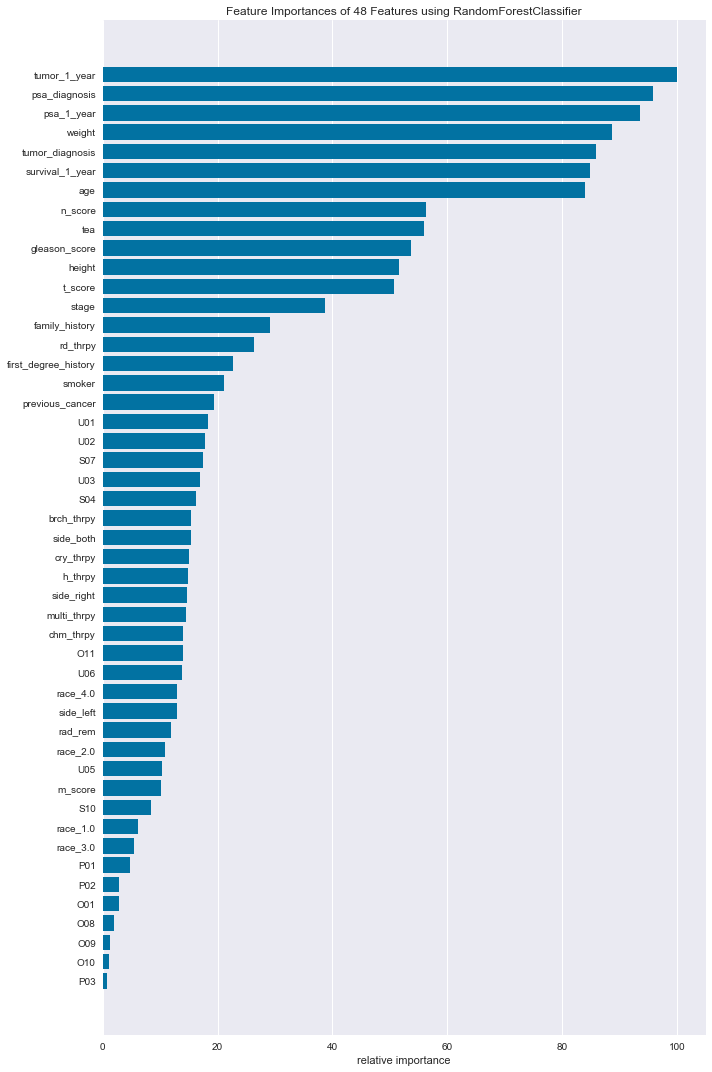

In [336]:
fig = plt.figure(figsize = (10,15))
ax = fig.add_subplot()
viz = FeatureImportances(clf, ax=ax)
viz.fit(x, y)
viz.poof()

In [337]:
np.sort(clf.feature_importances_)

array([0.00055545, 0.00077576, 0.00089737, 0.00141542, 0.00201101,
       0.00201185, 0.00337316, 0.00396301, 0.00441967, 0.00605742,
       0.00730264, 0.00752841, 0.00785656, 0.00855121, 0.00930475,
       0.00937312, 0.00998236, 0.01010477, 0.0101663 , 0.01052542,
       0.01059706, 0.01073184, 0.01091472, 0.01106577, 0.01111599,
       0.0117338 , 0.01224222, 0.01262548, 0.01285947, 0.01326529,
       0.01401325, 0.01534383, 0.01648746, 0.01905008, 0.0211425 ,
       0.0280221 , 0.03669874, 0.03735018, 0.03891633, 0.04052857,
       0.0407403 , 0.06081861, 0.06143521, 0.06217185, 0.06426505,
       0.06780913, 0.06944016, 0.07243931])

### Although we have the visualization for all 48 features in the dataset, we are going to use only the 29 optimal features that we have extracted using Random Forest.

In [338]:
x_rfe = rfecv.transform(x)

In [339]:
def classifier_metrics(estimator,y_pred):
    class_metrics = {'Accuracy' : metrics.accuracy_score(y, y_pred),
                     'Precision' : metrics.precision_score(y, y_pred),
                     'Recall' : metrics.recall_score(y, y_pred),
                     'F1 Score' : metrics.f1_score(y, y_pred)
                    }


    df_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    print('\nConfusion Matrix:')
    skplt.metrics.plot_confusion_matrix(y, y_pred)
    
    print('\nClassification Report:')
    print(metrics.classification_report(y,y_pred,digits=2))
    
    print('\nMetrics:')
    print(df_metrics)
    
    return  df_metrics

In [340]:
def plot_roc(model,x_test,y):
    model_proba = cross_val_predict(model, x_test, y, cv=3, n_jobs=-1, verbose=1, method = 'predict_proba')
    fig = plt.figure()
    ax1 = fig.add_subplot()
    skplt.metrics.plot_roc(y,model_proba ,figsize = (15,7),title_fontsize='large',text_fontsize='large')                
    return None

In [341]:
def precision_recall(model,x_test,y):
    model_proba = cross_val_predict(model, x_test, y, cv=3, n_jobs=-1, verbose=1, method = 'predict_proba')
    fig = plt.figure()
    ax1 = fig.add_subplot()
    skplt.metrics.plot_precision_recall(y,model_proba,figsize = (15,7),title_fontsize='large',text_fontsize='large')                 
    return None

### Logistic Regression

In [342]:
log = LogisticRegression(solver = 'liblinear', random_state = 100, penalty = 'l1', n_jobs = -1)
param_grid = {'C':[0.05,0.1,0.2]}
grid_search1= GridSearchCV(log,param_grid, cv=3, scoring = 'accuracy', n_jobs=-1, verbose = 2)
grid_search1.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search1.best_params_))
print("Best cross_val score : {}".format(grid_search1.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    5.9s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   10.8s finished


Best Parameters : {'C': 0.1}
Best cross_val score : 0.6520411549950216


In [343]:
logreg = LogisticRegression(solver = 'liblinear', random_state = 100, penalty = 'l1', n_jobs = -1, C=0.1)
logreg.fit(x_rfe,y)
log_pred = cross_val_predict(logreg, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished



Confusion Matrix:

Classification Report:
             precision    recall  f1-score   support

        0.0       0.69      0.71      0.70      8561
        1.0       0.60      0.57      0.59      6504

avg / total       0.65      0.65      0.65     15065


Metrics:
                  0
Accuracy   0.652041
Precision  0.601741
Recall     0.573801
F1 Score   0.587439


,0
Accuracy,0.652041
Precision,0.601741
Recall,0.573801
F1 Score,0.587439


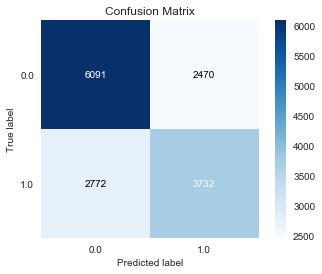

In [344]:
classifier_metrics(logreg,log_pred)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


<Figure size 432x288 with 0 Axes>

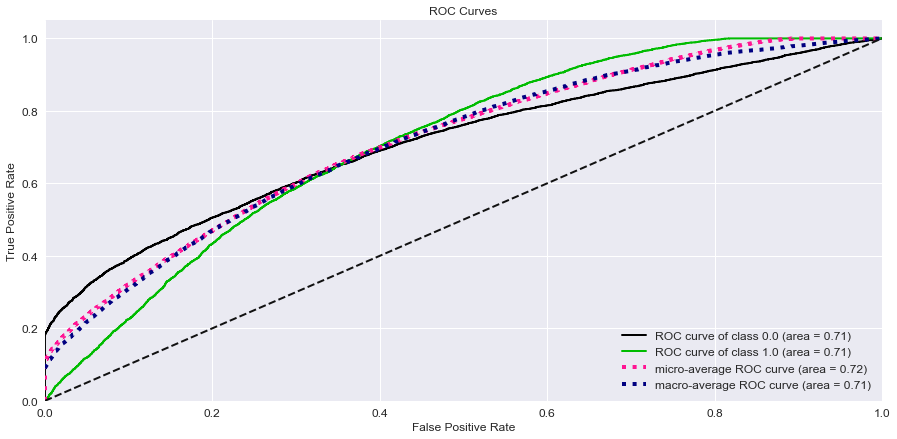

In [345]:
plot_roc(logreg,x_rfe,y)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


<Figure size 432x288 with 0 Axes>

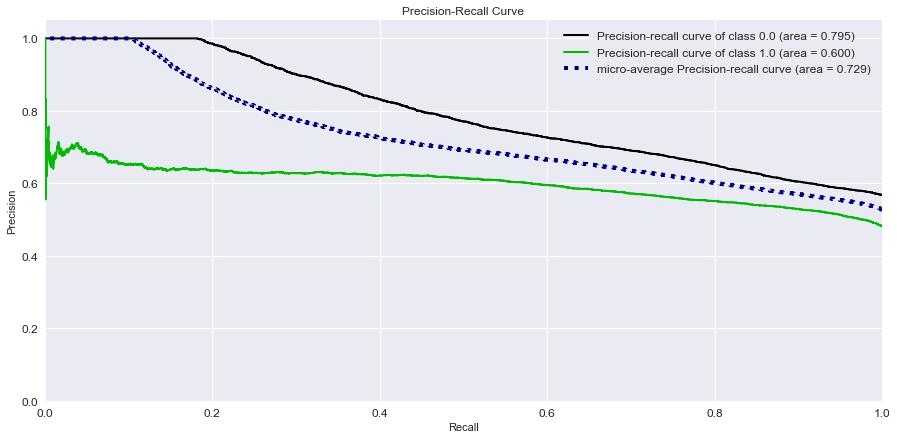

In [346]:
precision_recall(logreg,x_rfe,y)

### Random Forest

In [347]:
ranf = RandomForestClassifier(random_state=100, oob_score=True, n_jobs=-1, min_samples_leaf = 10)
param_grid = {'n_estimators':[150,200,250]}
grid_search3= GridSearchCV(ranf,param_grid, cv=3, scoring = 'accuracy', n_jobs=-1, verbose=2)
grid_search3.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search3.best_params_))
print("Best cross_val score : {}".format(grid_search3.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    7.0s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   12.6s finished


Best Parameters : {'n_estimators': 200}
Best cross_val score : 0.6704281447062728


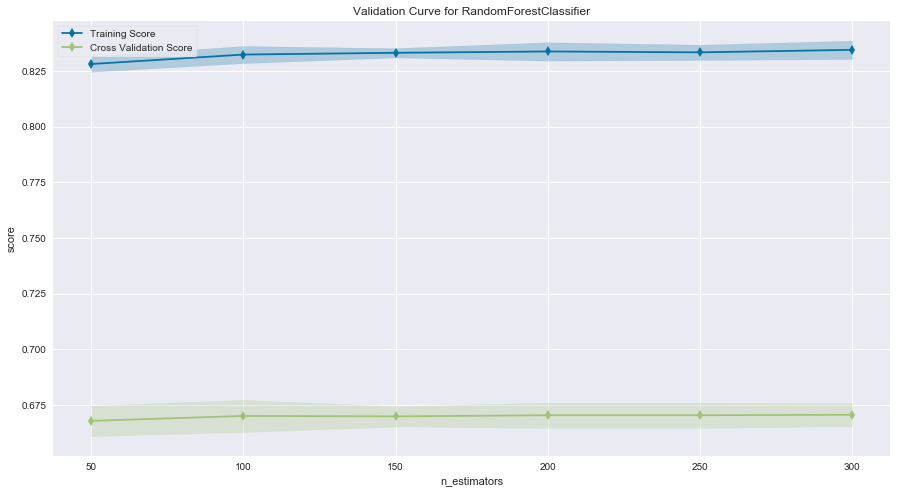

In [348]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
viz = ValidationCurve(ranf, ax=ax, param_name="n_estimators", param_range=np.arange(50,301,50), cv=3, scoring="accuracy")
viz.fit(x_rfe, y)
viz.poof()

### The cross validation score does not decrease as number of estimators increase. The training score seems to be a tad high as random forest can overfit the data easily. This can be controlled by setting higher values for 'min_samples_leaf' argument and with better hyperparameter tuning

In [349]:
ranfor = RandomForestClassifier(random_state=100, oob_score=True, n_jobs=-1, n_estimators=200, min_samples_leaf = 10)
ranfor.fit(x_rfe,y)
ranfor_pred = cross_val_predict(ranfor, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished



Confusion Matrix:

Classification Report:
             precision    recall  f1-score   support

        0.0       0.72      0.69      0.70      8561
        1.0       0.61      0.64      0.63      6504

avg / total       0.67      0.67      0.67     15065


Metrics:
                  0
Accuracy   0.670428
Precision  0.612780
Recall     0.642835
F1 Score   0.627448


,0
Accuracy,0.670428
Precision,0.612780
Recall,0.642835
F1 Score,0.627448


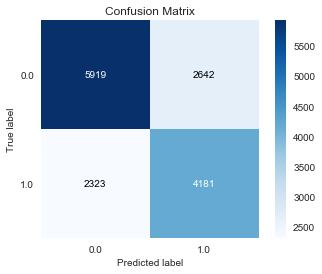

In [350]:
classifier_metrics(ranfor,ranfor_pred)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


<Figure size 432x288 with 0 Axes>

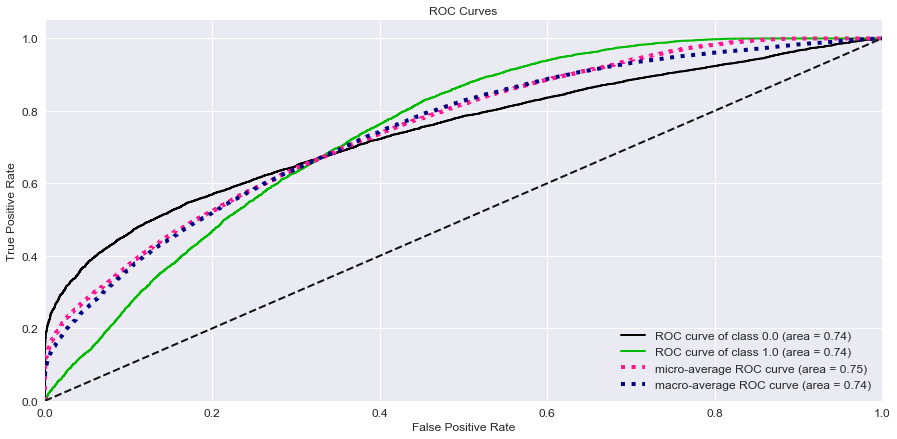

In [351]:
plot_roc(ranfor,x_rfe,y)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


<Figure size 432x288 with 0 Axes>

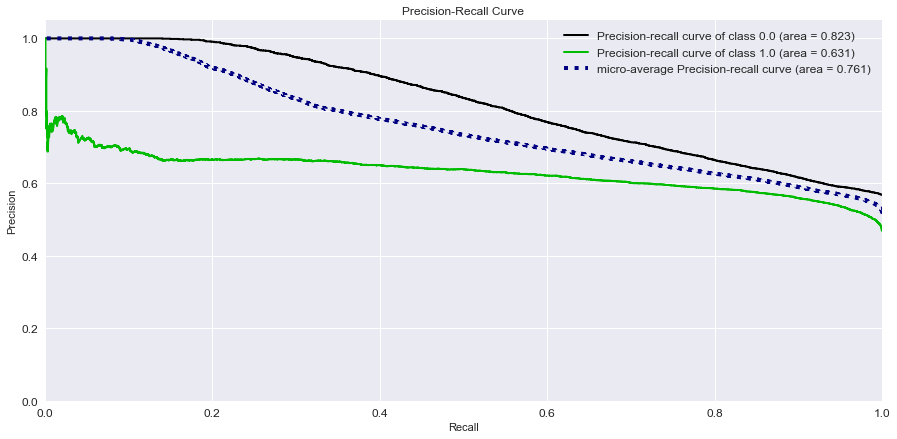

In [352]:
precision_recall(ranfor,x_rfe,y)

### We will go with the random forest model to score the test data as it gives us a slightly higher cross val predict score. With more hyperparameter tuning we can fine tune the models to improve accuracy. We can even use different boosting algorithms to improve model performance.

### Importing test data set

In [355]:
filepath1 = "D:\\adity\\Downloads\\Enova\\"
test = pd.read_csv(filepath1 + "test.csv", na_values = ['?'])
test.head()

,id,diagnosis_date,gleason_score,t_score,n_score,m_score,stage,age,race,height,...,symptoms,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,survival_7_years
0,20001,Oct-05,8.0,T3b,N0,M0,III,79.0,4.0,68.0,...,"U01,U02,S10",1,1,1,0,0,0,1,NaN,NaN
1,20002,Jun-02,10.0,T2c,N0,M0,IIB,84.0,2.0,70.0,...,"U01,U02,S07",1,0,0,1,0,0,1,NaN,NaN
2,20003,Mar-04,6.0,T4,N0,M0,IV,NaN,4.0,68.0,...,"U06,S07,O11",0,0,1,1,0,0,1,NaN,NaN
3,20004,Oct-03,7.0,T4,N1,M1a,IV,73.0,4.0,69.0,...,"S07,P03",1,0,1,0,1,0,1,0.0,NaN
4,20005,Mar-06,6.0,T1b,N0,M0,IIA,81.0,1.0,69.0,...,"U01,U03,U06,O11",0,0,1,1,0,0,1,NaN,NaN


### Handling of symptoms column

In [356]:
test_symptom = test['symptoms'].astype(str)
test_symp = []
for line in test_symptom:
    test_symp.append((line.strip()).split(','))

In [357]:
test_final = list(itertools.chain.from_iterable(test_symp))

### Creating a unique list of symptoms

In [358]:
test_mylist = list(set(test_final))
test_output = set()
for x in test_mylist:
    test_output.add(x)
print(test_output)

{'U06', 'O01', 'nan', 'O10', 'S07', 'S04', 'U02', 'O09', 'U01', 'U05', 'O11', 'U03', 'O08', 'P02', 'P03', 'P01', 'S10'}


In [359]:
j = 1
test_dic = {}
for i in test_output:
    test_col = []
    for line in test_symp:
        test_col.append(int(i in line))
    test_dic[i] = pd.Series(test_col)
    j+=1

In [360]:
test_out = pd.DataFrame(test_dic)

In [361]:
test_out.drop(['nan'], axis = 1, inplace = True)

In [362]:
test = pd.concat([test, test_out], axis=1)

### Creating dummy variables for race and side

In [363]:
test_race = pd.get_dummies(test['race'], prefix = 'race')
test_side = pd.get_dummies(test['side'], prefix = 'side')

In [364]:
test = pd.concat([test, test_race, test_side], axis=1)
test.drop(['race','side','symptoms'], axis = 1, inplace = True)

### Factorizing ordinal variables in the testset

In [365]:
test['gleason_score'] = pd.factorize(test['gleason_score'])[0]
test['t_score'] = pd.factorize(test['t_score'])[0]
test['n_score'] = pd.factorize(test['n_score'])[0]
test['m_score'] = pd.factorize(test['m_score'])[0]
test['stage'] = pd.factorize(test['stage'])[0]

### Subsetting the dataset with only the features selected in training

In [366]:
test1 = test[['gleason_score', 't_score', 'n_score', 'm_score', 'stage', 'age',
       'height', 'weight', 'family_history', 'first_degree_history',
       'previous_cancer', 'smoker', 'tumor_diagnosis', 'tumor_1_year',
       'psa_diagnosis', 'psa_1_year', 'tea', 'rd_thrpy', 'h_thrpy',
       'brch_thrpy', 'survival_1_year', 'U06', 'S07', 'S04', 'U02', 'U01',
       'U03', 'race_4.0', 'side_both']]

### Data Imputation

In [367]:
test_final = IterativeImputer().fit_transform(test1)

In [368]:
test_new = pd.DataFrame(test_final, columns = test1.columns, index = test1.index)

In [370]:
test_new.describe()

,gleason_score,t_score,n_score,m_score,stage,age,height,weight,family_history,first_degree_history,...,brch_thrpy,survival_1_year,U06,S07,S04,U02,U01,U03,race_4.0,side_both
count,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,...,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000
mean,2.548001,3.882751,0.473593,0.157228,1.624751,76.832724,69.158638,176.930909,0.420806,0.213569,...,0.246900,0.941089,0.198595,0.396236,0.250195,0.556240,0.604631,0.351401,0.743474,0.500043
std,2.070027,2.755071,0.672641,0.598491,1.030721,9.376818,1.127062,16.897067,0.580713,0.434195,...,0.431227,0.227650,0.398960,0.489136,0.433144,0.496849,0.488951,0.477429,0.436734,0.500022
min,-1.000000,0.000000,0.000000,0.000000,0.000000,35.000000,65.000000,123.000000,0.000000,-0.033782,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,0.000000,1.000000,71.000000,68.000000,166.722008,0.000000,0.000000,...,0.000000,0.971299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,0.000000,0.000000,2.000000,78.000000,69.000000,174.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,4.000000,6.000000,1.000000,0.000000,2.000000,84.000000,70.000000,184.000000,1.000000,0.175748,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,10.000000,9.000000,2.000000,3.000000,4.000000,108.000000,74.000000,317.000000,5.000000,5.000000,...,1.000000,1.341252,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Predictions

In [371]:
y_pred_test = ranfor.predict(test_new)
y_pred_df = pd.DataFrame(y_pred_test)
y_pred_df.to_csv('score.csv')

### References

#### https://en.wikipedia.org/wiki/Gleason_grading_system
#### http://www.cancer.org/treatment/understandingyourdiagnosis/understandingyourpathologyreport/prostatepathology/prostate-cancer-pathology